# Overview

This notebook shows how to run a Langeving simulation that combine metadynamic simulations with umbrella sampling simulations.

The notebook will be structured as follows:

 - Umbrella sampling in 1 dimension
 - Metadynamics and Umbrella sampling in 1 dimension
 - Metadynamics and Umbrella sampling in 2 dimensions

Some functions are taken from the Functions.ipynb file. Please refere to previous notebooks for more information.

In [1]:
# os.chdir(path)
#Import modules like numpy and matplotlib as well as functions defined in Functions.ipynb
%run Functions.ipynb

#make sure to run this cell in the right directory!!
path = os.getcwd()
print("The path to this notebook is:", path)

The path to this notebook is: /Users/matteo/Projects/MFI/Bjola_upgrade_report_files


In [2]:
#make sure to run this cell in the right directory!!
try: os.mkdir("HP_1D")
except: print("folder \"HP_1D\" already exists")
os.chdir("HP_1D")

# Umbrella sampling in 1 dimension

The analytical free energy surface will again be defined as $ y(x) = 7 ∗ x^4 − 23 ∗ x^2 $

Now, a free energy perturbation will be introduced. When using a static bias or attractive bias or umbrella samplin bias, one is usually referring to a harmonic potential of the form:

$hp(x) = \frac{\kappa}{2} * (x - x_0)^2$

$\kappa$ is the force constant and $x_0$ is a variables used to center the bias around the area of interst. The perturbated potential enegery can be visualised be adding the two functions $y(x)$ and $hp(x)$ together.

As can be seen in the figure of the cell below, the center region of the perturbated potential is now flat and easy to explore.

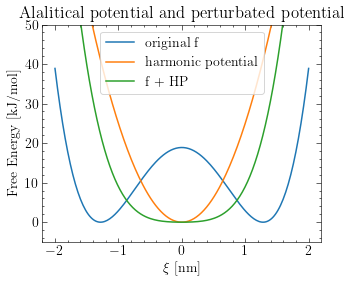

In [3]:
nbins = 200
min_x = -2           
max_x = 2 
grid_space = (max_x - min_x) / (nbins - 1)
x = np.linspace(min_x, max_x, nbins)
y = 7*x**4-23*x**2
y = y - min(y)

#Define the harmonic potential
hp = 50/2 * x**2

plt.plot(x, y, label="original f")
plt.plot(x, hp - min(hp),label="harmonic potential")
plt.plot(x, y + hp - min(y + hp), label="f + HP" )
plt.ylim(-5,50)
plt.ylabel("Free Energy [kJ/mol]")
plt.xlabel(r"$\xi$ [nm]")
plt.title("Alalitical potential and perturbated potential")
plt.legend()
plt.show()

Next, an umbrella sampling simulation will be performed using the harmonic potential defined in the cell above as a bias.

(Note that the function below is written to also allow metadynamcis simulations. Setting the height of the bias to 0 will block the build-up of a metadynamcis potential)

In [4]:
def run_langevin1D_hp(sim_len, kappa, hp_pos, sigma = 0.1, height = 1, biasfactor = 10):
    with open("plumed.dat","w") as f:
        print("""p: DISTANCE ATOMS=1,2 COMPONENTS
ff: MATHEVAL ARG=p.x PERIODIC=NO FUNC=(7*x^4-23*x^2)
bb: BIASVALUE ARG=ff
RESTRAINT ARG=p.x AT={} KAPPA={} LABEL=restraint
METAD ARG=p.x PACE=100 SIGMA={} HEIGHT={} GRID_MIN=-3 GRID_MAX=3 GRID_BIN=300 BIASFACTOR={} TEMP=120 CALC_RCT
PRINT FILE=position ARG=p.x STRIDE=10
""".format(hp_pos,kappa, sigma, height, biasfactor),file=f)

    with open("input","w") as f:
        print("""temperature 1
tstep 0.005
friction 1
dimension 1
nstep {}
ipos {}
periodic false""".format(sim_len, hp_pos),file=f)
        
    #Start simulation
    !plumed pesmd < input > /dev/null

In [5]:
os.chdir(path)
try: os.mkdir("HP_1D")
except: print("folder \"HP_1D\" already exists")
os.chdir("HP_1D")

#To run a simulation without Metadynamics, use a height of 0 !
run_hp_1D(100000, 50, 0.0, sigma = 0.1, height = 0.0, biasfactor = 10)

folder "HP_1D" already exists


NameError: name 'run_hp_1D' is not defined

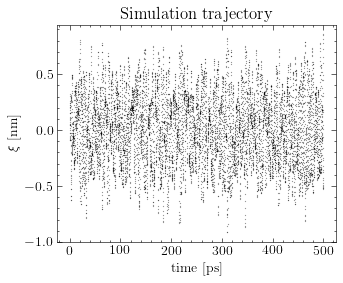

In [308]:
#Read the position and HILLS file
HILLS = load_HILLS_1D()
position = laod_position_1D()
time = laod_positiontime_1D()

#plot trajectory
plt.scatter(time, position, color="black",marker=".", s=0.1)
plt.xlabel("time [ps]")
plt.ylabel(r"$\xi$ [nm]")
plt.title("Simulation trajectory")
plt.show()

Next, define a function to anlyse the position and HILLS data using the MFI algorithm.

(Note: The main difference when analysing simulations with a harmonic potential using MFI is that the harmonic force needs to be defined and added to the bias force)

In [287]:
def MFI_1D_hp(kappa, hp_pos, bw = 0.02):
    
    #calculate some constants
    bw2 = bw**2
    stride = int(len(position) / len(HILLS[:,1]))
    const = (1 / (bw*np.sqrt(2*np.pi)*stride))
    kT = 1
    total_number_of_hills=len(HILLS[:,1])
    print("total number of hills:", total_number_of_hills)
    
    #define analytical harmonic FORCE (not energy!):
    F_harmonic = float(kappa)*(x-float(hp_pos)) 
    
    #initialise some force terms
    Fbias = np.zeros(len(x));
    Ftot_num = np.zeros(len(x));
    Ftot_den = np.zeros(len(x));

    for i in range(total_number_of_hills):
        
        # Build metadynamics potential
        s = HILLS[i, 1]  # center position of gausian
        sigma_meta2 = HILLS[i, 2] ** 2  # width of gausian
        gamma = HILLS[i, 4]  #scaling factor of gausian
        height_meta = HILLS[i, 3] * ((gamma - 1) / (gamma))  # Height of Gausian
        kernelmeta = np.exp(-0.5 * (((x - s) ** 2) / (sigma_meta2)))
        Fbias = Fbias + height_meta * kernelmeta * ((x - s) / (sigma_meta2)) #Bias force due to Metadynamics potentials

        # Estimate the biased proabability density
        pb_t = np.zeros(len(x))
        Fpbt = np.zeros(len(x))
        data = position[i * stride: (i + 1) * stride] #positons of window of constant bias force.
        for j in range(stride):
            kernel = const * np.exp(- (x - data[j])**2 / (2*bw2) ) #probability density of 1 datapoint
            pb_t = pb_t + kernel #probability density of window 
            Fpbt = Fpbt + kT * kernel * (x - data[j]) / bw2

        # Estimate of the Mean Force
        Ftot_den = Ftot_den + pb_t   #total probability density
        dfds = np.divide(Fpbt, pb_t, out=np.zeros_like(Fpbt), where=pb_t != 0) + Fbias - F_harmonic
        Ftot_num = Ftot_num + pb_t * dfds
        Ftot = np.divide(Ftot_num, Ftot_den, out=np.zeros_like(Ftot_num), where=Ftot_den != 0) #total force

#         if (i+1) % (total_number_of_hills/10) == 0:
#             print(str(i+1) + " / " + str(total_number_of_hills))
           
    return [Ftot_den, Ftot]

total number of hills: 1000


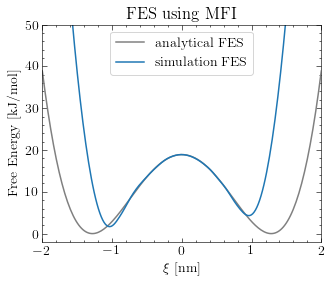

In [313]:
#Define constants
bw = 0.02      # bw: bandwidth for the KDE of the biased probability density
bw2 = bw**2
kT = 1          # kT:       value of kT
stride = int(len(position) / len(HILLS[:,1]))     
const = (1 / (bw*np.sqrt(2*np.pi)*stride))
total_number_of_hills=len(HILLS[:,1])
print("total number of hills:", total_number_of_hills)


#Calculate the mean force of the ubrella sampling simulation
[Ftot_den, Ftot] = MFI_hp_1D(position, HILLS, 50, 0.0, bw = 0.05)

#integrate the forces
FES = intg_simps_1D(x, Ftot)

#adjust the altitude of the FES
FES = FES + (y[100] - FES[100])

#plot analytical fes
plt.plot(x, y, color="grey", label="analytical FES")

#plot fes
plt.plot(x, FES, label="simulation FES")
plt.xlabel("$\\xi$ [nm]")
plt.ylabel("Free Energy [kJ/mol]")
plt.title("FES using MFI")
plt.xlim(-2,2)
plt.ylim(-2,50)
plt.legend()
# plt.savefig(str(path) + '/MFI_fes_7x^4-23x^2.png', dpi=600, bbox_inches='tight')
plt.show()

As is can be seen in the graph of the cell above, the calculated FES is in good agreement with the analytical FES, but only for those values that have been explored. Values too far from the the center of the harmonic potential couldn't be explored. To explore those values using umbrella sapling techniques, additional simulation with biases in different positions need to be conducted and patched together. When using umbrella integration or MFI, the patching can be done very easy. 

As an alternative to running multiple umbrella sampling simulations with harmonic potential in diffrent positions, a metadynamics simulation will be complemented with a umbrella sampling simulation, which will be presented in the next section.

# Metadynamics and Umbrella sampling in 1 dimension


### Metadynamics as base simulation

To start, a short metadynamics simulation will be run on the analytical surface. For more information, please refere the the second notebook "2 - Mean Force Integration"


In [330]:
os.chdir(path)
try: os.mkdir("HP_1D")
except: print("folder \"HP_1D\" already exists")
os.chdir("HP_1D")

run_langevin1D(200000, sigma=0.1, height=0.5, biasfactor=10)

folder "HP_1D" already exists
PLUMED: PLUMED is starting
PLUMED: Version: 2.7.0 (git: Unknown) compiled on Mar  8 2021 at 17:46:23
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /home/antoniu/.local/anaconda3/envs/plumed-masterclass/lib/plumed
PLUMED: For installed feature, see /home/antoniu/.local/anaconda3/envs/plumed-masterclass/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: pesmd
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 2
PLUMED: File suffix: 
PLUMED: FILE: plumed.dat
PLUMED: Action DISTANCE
PLUMED:   with label p
PLUMED:   between atoms 1 2
PLUMED:   using periodic boundary conditions
PLUMED:   added component to this action:  p.x 
PLUMED:   added component to this action:  p.y 
PLUMED:   added component to this action:  p.z 
PLUMED:   WARNING: components wi

Doing step 7120
Doing step 7140
Doing step 7160
Doing step 7180
Doing step 7200
Doing step 7220
Doing step 7240
Doing step 7260
Doing step 7280
Doing step 7300
Doing step 7320
Doing step 7340
Doing step 7360
Doing step 7380
Doing step 7400
Doing step 7420
Doing step 7440
Doing step 7460
Doing step 7480
Doing step 7500
Doing step 7520
Doing step 7540
Doing step 7560
Doing step 7580
Doing step 7600
Doing step 7620
Doing step 7640
Doing step 7660
Doing step 7680
Doing step 7700
Doing step 7720
Doing step 7740
Doing step 7760
Doing step 7780
Doing step 7800
Doing step 7820
Doing step 7840
Doing step 7860
Doing step 7880
Doing step 7900
Doing step 7920
Doing step 7940
Doing step 7960
Doing step 7980
Doing step 8000
Doing step 8020
Doing step 8040
Doing step 8060
Doing step 8080
Doing step 8100
Doing step 8120
Doing step 8140
Doing step 8160
Doing step 8180
Doing step 8200
Doing step 8220
Doing step 8240
Doing step 8260
Doing step 8280
Doing step 8300
Doing step 8320
Doing step 8340
Doing st

Doing step 18800
Doing step 18820
Doing step 18840
Doing step 18860
Doing step 18880
Doing step 18900
Doing step 18920
Doing step 18940
Doing step 18960
Doing step 18980
Doing step 19000
Doing step 19020
Doing step 19040
Doing step 19060
Doing step 19080
Doing step 19100
Doing step 19120
Doing step 19140
Doing step 19160
Doing step 19180
Doing step 19200
Doing step 19220
Doing step 19240
Doing step 19260
Doing step 19280
Doing step 19300
Doing step 19320
Doing step 19340
Doing step 19360
Doing step 19380
Doing step 19400
Doing step 19420
Doing step 19440
Doing step 19460
Doing step 19480
Doing step 19500
Doing step 19520
Doing step 19540
Doing step 19560
Doing step 19580
Doing step 19600
Doing step 19620
Doing step 19640
Doing step 19660
Doing step 19680
Doing step 19700
Doing step 19720
Doing step 19740
Doing step 19760
Doing step 19780
Doing step 19800
Doing step 19820
Doing step 19840
Doing step 19860
Doing step 19880
Doing step 19900
Doing step 19920
Doing step 19940
Doing step 199

Doing step 30360
Doing step 30380
Doing step 30400
Doing step 30420
Doing step 30440
Doing step 30460
Doing step 30480
Doing step 30500
Doing step 30520
Doing step 30540
Doing step 30560
Doing step 30580
Doing step 30600
Doing step 30620
Doing step 30640
Doing step 30660
Doing step 30680
Doing step 30700
Doing step 30720
Doing step 30740
Doing step 30760
Doing step 30780
Doing step 30800
Doing step 30820
Doing step 30840
Doing step 30860
Doing step 30880
Doing step 30900
Doing step 30920
Doing step 30940
Doing step 30960
Doing step 30980
Doing step 31000
Doing step 31020
Doing step 31040
Doing step 31060
Doing step 31080
Doing step 31100
Doing step 31120
Doing step 31140
Doing step 31160
Doing step 31180
Doing step 31200
Doing step 31220
Doing step 31240
Doing step 31260
Doing step 31280
Doing step 31300
Doing step 31320
Doing step 31340
Doing step 31360
Doing step 31380
Doing step 31400
Doing step 31420
Doing step 31440
Doing step 31460
Doing step 31480
Doing step 31500
Doing step 315

Doing step 42420
Doing step 42440
Doing step 42460
Doing step 42480
Doing step 42500
Doing step 42520
Doing step 42540
Doing step 42560
Doing step 42580
Doing step 42600
Doing step 42620
Doing step 42640
Doing step 42660
Doing step 42680
Doing step 42700
Doing step 42720
Doing step 42740
Doing step 42760
Doing step 42780
Doing step 42800
Doing step 42820
Doing step 42840
Doing step 42860
Doing step 42880
Doing step 42900
Doing step 42920
Doing step 42940
Doing step 42960
Doing step 42980
Doing step 43000
Doing step 43020
Doing step 43040
Doing step 43060
Doing step 43080
Doing step 43100
Doing step 43120
Doing step 43140
Doing step 43160
Doing step 43180
Doing step 43200
Doing step 43220
Doing step 43240
Doing step 43260
Doing step 43280
Doing step 43300
Doing step 43320
Doing step 43340
Doing step 43360
Doing step 43380
Doing step 43400
Doing step 43420
Doing step 43440
Doing step 43460
Doing step 43480
Doing step 43500
Doing step 43520
Doing step 43540
Doing step 43560
Doing step 435

Doing step 54160
Doing step 54180
Doing step 54200
Doing step 54220
Doing step 54240
Doing step 54260
Doing step 54280
Doing step 54300
Doing step 54320
Doing step 54340
Doing step 54360
Doing step 54380
Doing step 54400
Doing step 54420
Doing step 54440
Doing step 54460
Doing step 54480
Doing step 54500
Doing step 54520
Doing step 54540
Doing step 54560
Doing step 54580
Doing step 54600
Doing step 54620
Doing step 54640
Doing step 54660
Doing step 54680
Doing step 54700
Doing step 54720
Doing step 54740
Doing step 54760
Doing step 54780
Doing step 54800
Doing step 54820
Doing step 54840
Doing step 54860
Doing step 54880
Doing step 54900
Doing step 54920
Doing step 54940
Doing step 54960
Doing step 54980
Doing step 55000
Doing step 55020
Doing step 55040
Doing step 55060
Doing step 55080
Doing step 55100
Doing step 55120
Doing step 55140
Doing step 55160
Doing step 55180
Doing step 55200
Doing step 55220
Doing step 55240
Doing step 55260
Doing step 55280
Doing step 55300
Doing step 553

Doing step 65960
Doing step 65980
Doing step 66000
Doing step 66020
Doing step 66040
Doing step 66060
Doing step 66080
Doing step 66100
Doing step 66120
Doing step 66140
Doing step 66160
Doing step 66180
Doing step 66200
Doing step 66220
Doing step 66240
Doing step 66260
Doing step 66280
Doing step 66300
Doing step 66320
Doing step 66340
Doing step 66360
Doing step 66380
Doing step 66400
Doing step 66420
Doing step 66440
Doing step 66460
Doing step 66480
Doing step 66500
Doing step 66520
Doing step 66540
Doing step 66560
Doing step 66580
Doing step 66600
Doing step 66620
Doing step 66640
Doing step 66660
Doing step 66680
Doing step 66700
Doing step 66720
Doing step 66740
Doing step 66760
Doing step 66780
Doing step 66800
Doing step 66820
Doing step 66840
Doing step 66860
Doing step 66880
Doing step 66900
Doing step 66920
Doing step 66940
Doing step 66960
Doing step 66980
Doing step 67000
Doing step 67020
Doing step 67040
Doing step 67060
Doing step 67080
Doing step 67100
Doing step 671

Doing step 76220
Doing step 76240
Doing step 76260
Doing step 76280
Doing step 76300
Doing step 76320
Doing step 76340
Doing step 76360
Doing step 76380
Doing step 76400
Doing step 76420
Doing step 76440
Doing step 76460
Doing step 76480
Doing step 76500
Doing step 76520
Doing step 76540
Doing step 76560
Doing step 76580
Doing step 76600
Doing step 76620
Doing step 76640
Doing step 76660
Doing step 76680
Doing step 76700
Doing step 76720
Doing step 76740
Doing step 76760
Doing step 76780
Doing step 76800
Doing step 76820
Doing step 76840
Doing step 76860
Doing step 76880
Doing step 76900
Doing step 76920
Doing step 76940
Doing step 76960
Doing step 76980
Doing step 77000
Doing step 77020
Doing step 77040
Doing step 77060
Doing step 77080
Doing step 77100
Doing step 77120
Doing step 77140
Doing step 77160
Doing step 77180
Doing step 77200
Doing step 77220
Doing step 77240
Doing step 77260
Doing step 77280
Doing step 77300
Doing step 77320
Doing step 77340
Doing step 77360
Doing step 773

Doing step 87580
Doing step 87600
Doing step 87620
Doing step 87640
Doing step 87660
Doing step 87680
Doing step 87700
Doing step 87720
Doing step 87740
Doing step 87760
Doing step 87780
Doing step 87800
Doing step 87820
Doing step 87840
Doing step 87860
Doing step 87880
Doing step 87900
Doing step 87920
Doing step 87940
Doing step 87960
Doing step 87980
Doing step 88000
Doing step 88020
Doing step 88040
Doing step 88060
Doing step 88080
Doing step 88100
Doing step 88120
Doing step 88140
Doing step 88160
Doing step 88180
Doing step 88200
Doing step 88220
Doing step 88240
Doing step 88260
Doing step 88280
Doing step 88300
Doing step 88320
Doing step 88340
Doing step 88360
Doing step 88380
Doing step 88400
Doing step 88420
Doing step 88440
Doing step 88460
Doing step 88480
Doing step 88500
Doing step 88520
Doing step 88540
Doing step 88560
Doing step 88580
Doing step 88600
Doing step 88620
Doing step 88640
Doing step 88660
Doing step 88680
Doing step 88700
Doing step 88720
Doing step 887

Doing step 97240
Doing step 97260
Doing step 97280
Doing step 97300
Doing step 97320
Doing step 97340
Doing step 97360
Doing step 97380
Doing step 97400
Doing step 97420
Doing step 97440
Doing step 97460
Doing step 97480
Doing step 97500
Doing step 97520
Doing step 97540
Doing step 97560
Doing step 97580
Doing step 97600
Doing step 97620
Doing step 97640
Doing step 97660
Doing step 97680
Doing step 97700
Doing step 97720
Doing step 97740
Doing step 97760
Doing step 97780
Doing step 97800
Doing step 97820
Doing step 97840
Doing step 97860
Doing step 97880
Doing step 97900
Doing step 97920
Doing step 97940
Doing step 97960
Doing step 97980
Doing step 98000
Doing step 98020
Doing step 98040
Doing step 98060
Doing step 98080
Doing step 98100
Doing step 98120
Doing step 98140
Doing step 98160
Doing step 98180
Doing step 98200
Doing step 98220
Doing step 98240
Doing step 98260
Doing step 98280
Doing step 98300
Doing step 98320
Doing step 98340
Doing step 98360
Doing step 98380
Doing step 984

Doing step 106500
Doing step 106520
Doing step 106540
Doing step 106560
Doing step 106580
Doing step 106600
Doing step 106620
Doing step 106640
Doing step 106660
Doing step 106680
Doing step 106700
Doing step 106720
Doing step 106740
Doing step 106760
Doing step 106780
Doing step 106800
Doing step 106820
Doing step 106840
Doing step 106860
Doing step 106880
Doing step 106900
Doing step 106920
Doing step 106940
Doing step 106960
Doing step 106980
Doing step 107000
Doing step 107020
Doing step 107040
Doing step 107060
Doing step 107080
Doing step 107100
Doing step 107120
Doing step 107140
Doing step 107160
Doing step 107180
Doing step 107200
Doing step 107220
Doing step 107240
Doing step 107260
Doing step 107280
Doing step 107300
Doing step 107320
Doing step 107340
Doing step 107360
Doing step 107380
Doing step 107400
Doing step 107420
Doing step 107440
Doing step 107460
Doing step 107480
Doing step 107500
Doing step 107520
Doing step 107540
Doing step 107560
Doing step 107580
Doing step

Doing step 115940
Doing step 115960
Doing step 115980
Doing step 116000
Doing step 116020
Doing step 116040
Doing step 116060
Doing step 116080
Doing step 116100
Doing step 116120
Doing step 116140
Doing step 116160
Doing step 116180
Doing step 116200
Doing step 116220
Doing step 116240
Doing step 116260
Doing step 116280
Doing step 116300
Doing step 116320
Doing step 116340
Doing step 116360
Doing step 116380
Doing step 116400
Doing step 116420
Doing step 116440
Doing step 116460
Doing step 116480
Doing step 116500
Doing step 116520
Doing step 116540
Doing step 116560
Doing step 116580
Doing step 116600
Doing step 116620
Doing step 116640
Doing step 116660
Doing step 116680
Doing step 116700
Doing step 116720
Doing step 116740
Doing step 116760
Doing step 116780
Doing step 116800
Doing step 116820
Doing step 116840
Doing step 116860
Doing step 116880
Doing step 116900
Doing step 116920
Doing step 116940
Doing step 116960
Doing step 116980
Doing step 117000
Doing step 117020
Doing step

Doing step 125400
Doing step 125420
Doing step 125440
Doing step 125460
Doing step 125480
Doing step 125500
Doing step 125520
Doing step 125540
Doing step 125560
Doing step 125580
Doing step 125600
Doing step 125620
Doing step 125640
Doing step 125660
Doing step 125680
Doing step 125700
Doing step 125720
Doing step 125740
Doing step 125760
Doing step 125780
Doing step 125800
Doing step 125820
Doing step 125840
Doing step 125860
Doing step 125880
Doing step 125900
Doing step 125920
Doing step 125940
Doing step 125960
Doing step 125980
Doing step 126000
Doing step 126020
Doing step 126040
Doing step 126060
Doing step 126080
Doing step 126100
Doing step 126120
Doing step 126140
Doing step 126160
Doing step 126180
Doing step 126200
Doing step 126220
Doing step 126240
Doing step 126260
Doing step 126280
Doing step 126300
Doing step 126320
Doing step 126340
Doing step 126360
Doing step 126380
Doing step 126400
Doing step 126420
Doing step 126440
Doing step 126460
Doing step 126480
Doing step

Doing step 134800
Doing step 134820
Doing step 134840
Doing step 134860
Doing step 134880
Doing step 134900
Doing step 134920
Doing step 134940
Doing step 134960
Doing step 134980
Doing step 135000
Doing step 135020
Doing step 135040
Doing step 135060
Doing step 135080
Doing step 135100
Doing step 135120
Doing step 135140
Doing step 135160
Doing step 135180
Doing step 135200
Doing step 135220
Doing step 135240
Doing step 135260
Doing step 135280
Doing step 135300
Doing step 135320
Doing step 135340
Doing step 135360
Doing step 135380
Doing step 135400
Doing step 135420
Doing step 135440
Doing step 135460
Doing step 135480
Doing step 135500
Doing step 135520
Doing step 135540
Doing step 135560
Doing step 135580
Doing step 135600
Doing step 135620
Doing step 135640
Doing step 135660
Doing step 135680
Doing step 135700
Doing step 135720
Doing step 135740
Doing step 135760
Doing step 135780
Doing step 135800
Doing step 135820
Doing step 135840
Doing step 135860
Doing step 135880
Doing step

Doing step 145480
Doing step 145500
Doing step 145520
Doing step 145540
Doing step 145560
Doing step 145580
Doing step 145600
Doing step 145620
Doing step 145640
Doing step 145660
Doing step 145680
Doing step 145700
Doing step 145720
Doing step 145740
Doing step 145760
Doing step 145780
Doing step 145800
Doing step 145820
Doing step 145840
Doing step 145860
Doing step 145880
Doing step 145900
Doing step 145920
Doing step 145940
Doing step 145960
Doing step 145980
Doing step 146000
Doing step 146020
Doing step 146040
Doing step 146060
Doing step 146080
Doing step 146100
Doing step 146120
Doing step 146140
Doing step 146160
Doing step 146180
Doing step 146200
Doing step 146220
Doing step 146240
Doing step 146260
Doing step 146280
Doing step 146300
Doing step 146320
Doing step 146340
Doing step 146360
Doing step 146380
Doing step 146400
Doing step 146420
Doing step 146440
Doing step 146460
Doing step 146480
Doing step 146500
Doing step 146520
Doing step 146540
Doing step 146560
Doing step

Doing step 156240
Doing step 156260
Doing step 156280
Doing step 156300
Doing step 156320
Doing step 156340
Doing step 156360
Doing step 156380
Doing step 156400
Doing step 156420
Doing step 156440
Doing step 156460
Doing step 156480
Doing step 156500
Doing step 156520
Doing step 156540
Doing step 156560
Doing step 156580
Doing step 156600
Doing step 156620
Doing step 156640
Doing step 156660
Doing step 156680
Doing step 156700
Doing step 156720
Doing step 156740
Doing step 156760
Doing step 156780
Doing step 156800
Doing step 156820
Doing step 156840
Doing step 156860
Doing step 156880
Doing step 156900
Doing step 156920
Doing step 156940
Doing step 156960
Doing step 156980
Doing step 157000
Doing step 157020
Doing step 157040
Doing step 157060
Doing step 157080
Doing step 157100
Doing step 157120
Doing step 157140
Doing step 157160
Doing step 157180
Doing step 157200
Doing step 157220
Doing step 157240
Doing step 157260
Doing step 157280
Doing step 157300
Doing step 157320
Doing step

Doing step 165380
Doing step 165400
Doing step 165420
Doing step 165440
Doing step 165460
Doing step 165480
Doing step 165500
Doing step 165520
Doing step 165540
Doing step 165560
Doing step 165580
Doing step 165600
Doing step 165620
Doing step 165640
Doing step 165660
Doing step 165680
Doing step 165700
Doing step 165720
Doing step 165740
Doing step 165760
Doing step 165780
Doing step 165800
Doing step 165820
Doing step 165840
Doing step 165860
Doing step 165880
Doing step 165900
Doing step 165920
Doing step 165940
Doing step 165960
Doing step 165980
Doing step 166000
Doing step 166020
Doing step 166040
Doing step 166060
Doing step 166080
Doing step 166100
Doing step 166120
Doing step 166140
Doing step 166160
Doing step 166180
Doing step 166200
Doing step 166220
Doing step 166240
Doing step 166260
Doing step 166280
Doing step 166300
Doing step 166320
Doing step 166340
Doing step 166360
Doing step 166380
Doing step 166400
Doing step 166420
Doing step 166440
Doing step 166460
Doing step

Doing step 176300
Doing step 176320
Doing step 176340
Doing step 176360
Doing step 176380
Doing step 176400
Doing step 176420
Doing step 176440
Doing step 176460
Doing step 176480
Doing step 176500
Doing step 176520
Doing step 176540
Doing step 176560
Doing step 176580
Doing step 176600
Doing step 176620
Doing step 176640
Doing step 176660
Doing step 176680
Doing step 176700
Doing step 176720
Doing step 176740
Doing step 176760
Doing step 176780
Doing step 176800
Doing step 176820
Doing step 176840
Doing step 176860
Doing step 176880
Doing step 176900
Doing step 176920
Doing step 176940
Doing step 176960
Doing step 176980
Doing step 177000
Doing step 177020
Doing step 177040
Doing step 177060
Doing step 177080
Doing step 177100
Doing step 177120
Doing step 177140
Doing step 177160
Doing step 177180
Doing step 177200
Doing step 177220
Doing step 177240
Doing step 177260
Doing step 177280
Doing step 177300
Doing step 177320
Doing step 177340
Doing step 177360
Doing step 177380
Doing step

Doing step 185760
Doing step 185780
Doing step 185800
Doing step 185820
Doing step 185840
Doing step 185860
Doing step 185880
Doing step 185900
Doing step 185920
Doing step 185940
Doing step 185960
Doing step 185980
Doing step 186000
Doing step 186020
Doing step 186040
Doing step 186060
Doing step 186080
Doing step 186100
Doing step 186120
Doing step 186140
Doing step 186160
Doing step 186180
Doing step 186200
Doing step 186220
Doing step 186240
Doing step 186260
Doing step 186280
Doing step 186300
Doing step 186320
Doing step 186340
Doing step 186360
Doing step 186380
Doing step 186400
Doing step 186420
Doing step 186440
Doing step 186460
Doing step 186480
Doing step 186500
Doing step 186520
Doing step 186540
Doing step 186560
Doing step 186580
Doing step 186600
Doing step 186620
Doing step 186640
Doing step 186660
Doing step 186680
Doing step 186700
Doing step 186720
Doing step 186740
Doing step 186760
Doing step 186780
Doing step 186800
Doing step 186820
Doing step 186840
Doing step

Doing step 195260
Doing step 195280
Doing step 195300
Doing step 195320
Doing step 195340
Doing step 195360
Doing step 195380
Doing step 195400
Doing step 195420
Doing step 195440
Doing step 195460
Doing step 195480
Doing step 195500
Doing step 195520
Doing step 195540
Doing step 195560
Doing step 195580
Doing step 195600
Doing step 195620
Doing step 195640
Doing step 195660
Doing step 195680
Doing step 195700
Doing step 195720
Doing step 195740
Doing step 195760
Doing step 195780
Doing step 195800
Doing step 195820
Doing step 195840
Doing step 195860
Doing step 195880
Doing step 195900
Doing step 195920
Doing step 195940
Doing step 195960
Doing step 195980
Doing step 196000
Doing step 196020
Doing step 196040
Doing step 196060
Doing step 196080
Doing step 196100
Doing step 196120
Doing step 196140
Doing step 196160
Doing step 196180
Doing step 196200
Doing step 196220
Doing step 196240
Doing step 196260
Doing step 196280
Doing step 196300
Doing step 196320
Doing step 196340
Doing step

In [331]:
HILLS = load_HILLS_1D()
position = laod_position_1D()
                      
#Define constants
bw = 0.02      # bw: bandwidth for the KDE of the biased probability density
bw2 = bw**2
kT = 1          # kT:       value of kT
stride = int(len(position) / len(HILLS[:,1]))     
const = (1 / (bw*np.sqrt(2*np.pi)*stride))
total_number_of_hills=len(HILLS[:,1])
print("total number of hills:", total_number_of_hills)

#Analyze trajectory to obtain mean force Ftot
[Ftot_den, Ftot] = MFI_1D_simple()

# Integrate Ftot, obtain FES 
FES = intg_1D(Ftot)

# calculate error  
(AD, AAD) = error_1D(FES)
(AD_centre, AAD_centre) = error_1D_centre(FES, -1.75, 1.75)

total number of hills: 2000
200 / 2000
400 / 2000
600 / 2000
800 / 2000
1000 / 2000
1200 / 2000
1400 / 2000
1600 / 2000
1800 / 2000
2000 / 2000
The AAD of the FES is: 0.4117452953302234
The AAD of the FES from x=-1.75 to x=1.75 is: 0.30337837054891936


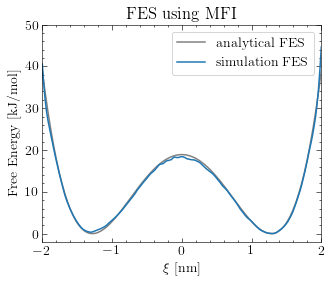

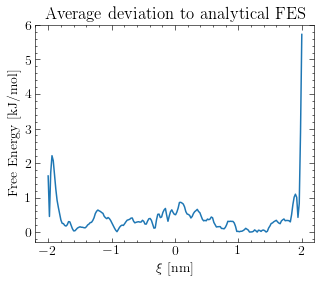

In [332]:
#plot analytical fes
plt.plot(x, y, color="grey", label="analytical FES")

#plot fes
plt.plot(x, FES, label="simulation FES")
plt.xlabel("$\\xi$ [nm]")
plt.ylabel("Free Energy [kJ/mol]")
plt.title("FES using MFI")
plt.xlim(-2,2)
plt.ylim(-2,50)
plt.legend()
plt.show()

#plot error
plt.plot(x, AD)
plt.xlabel("$\\xi$ [nm]")
plt.ylabel("Free Energy [kJ/mol]")
plt.title("Average deviation to analytical FES")
plt.show()

Although metadynamcis alone is already a very good method to sample transition regoins and relaibly calculate the FES, in some cases some local regions of the surface aren't converged yet, or not as smooth as expected.

In the first graph of the cell above, the centre region associated with a higher energy deoesn't seem to be captured too well. It is possible to run an additional simulation and constrain it to the centre regin using a harmonic potential, and also use meatadynamics to make sure that all of that region is sampled sufficiently.

In this exapmle, on could also have run the simulation for a little longer, which would have been enough to capture the centre region better. In other examples however, it might be more difficult to converge certain region, and it might not be able to do this after the simulation.

Now, the force terms are save, and patched with force terms of a simulation that uses Metadynamics and Umbrella sampling.

In [333]:
Ftot_den0 = Ftot_den
Ftot0 = Ftot
AD0 = AD

### Additional Metadynamics and Umbrella sampling

In [334]:
run_hp_1D(100000, 50, 0.0, sigma = 0.1, height = 0.1, biasfactor = 10)


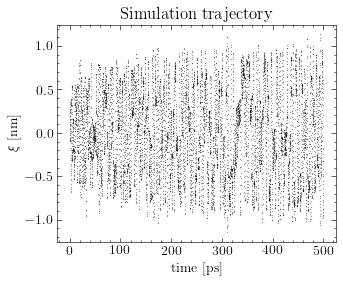

In [335]:
HILLS = load_HILLS_1D()
position = laod_position_1D()
time = laod_positiontime_1D()

#plot trajectory
plt.scatter(time, position, color="black",marker=".", s=0.1)
plt.xlabel("time [ps]")
plt.ylabel(r"$\xi$ [nm]")
plt.title("Simulation trajectory")
plt.show()

total number of hills: 1000


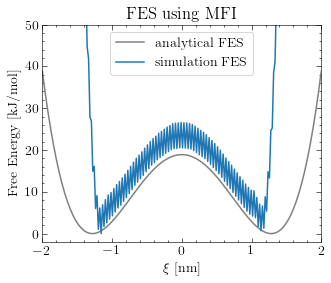

In [336]:
[Ftot_den, Ftot] = MFI_hp_1D(position, HILLS, 50, 0.0, bw = 0.05)

FES = FES + (y[100] - FES[100])

FES = intg_simps_1D(x, Ftot)

#plot analytical fes
plt.plot(x, y, color="grey", label="analytical FES")

#plot fes
plt.plot(x, FES, label="simulation FES")
plt.xlabel("$\\xi$ [nm]")
plt.ylabel("Free Energy [kJ/mol]")
plt.title("FES using MFI")
plt.xlim(-2,2)
plt.ylim(-2,50)
plt.legend()
# plt.savefig(str(path) + '/MFI_fes_7x^4-23x^2.png', dpi=600, bbox_inches='tight')
plt.show()

In [337]:
master = []
master.append([Ftot_den0, Ftot0])
master.append([Ftot_den, Ftot])


[Ftot_den_patch, Ftot_patch] = patch_1D(master)

The AAD of the FES is: 0.3050523993625622
The AAD of the FES from x=-1.75 to x=1.75 is: 0.18123759360282085


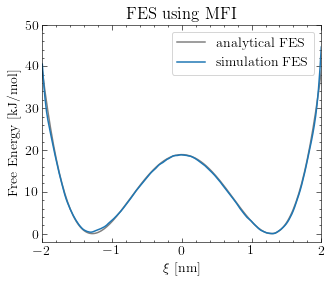

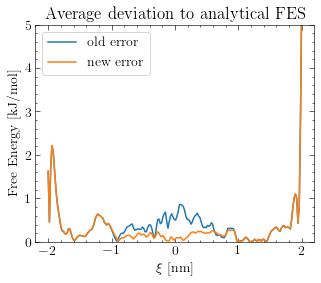

In [338]:
FES_patch = intg_simps_1D(x, Ftot_patch)

# calculate error  
(AD_patch, AAD_patch) = error_1D(FES_patch)
(AD_centre_patch, AAD_centre_patch) = error_1D_centre(FES_patch, -1.75, 1.75)

#plot analytical fes
plt.plot(x, y, color="grey", label="analytical FES")

#plot fes
plt.plot(x, FES_patch, label="simulation FES")
plt.xlabel("$\\xi$ [nm]")
plt.ylabel("Free Energy [kJ/mol]")
plt.title("FES using MFI")
plt.xlim(-2,2)
plt.ylim(-2,50)
plt.legend()
plt.show()


#plot error
plt.plot(x, AD0, label="old error")
plt.plot(x, AD_patch, label="new error")
plt.xlabel("$\\xi$ [nm]")
plt.ylabel("Free Energy [kJ/mol]")
plt.title("Average deviation to analytical FES")
plt.legend()
plt.ylim(0,5)
plt.show()

# Combining metadynamics with umbrella sampling in 2D

In [430]:
os.chdir(path)
try: os.mkdir("HP_2D")
except: print("folder \"HP_2D\" already exists")
os.chdir("HP_2D")

folder "HP_2D" already exists


### Define system

In [364]:
#Define Grid and theoretical function
nbins = 201
min_grid = -2
max_grid = 2
grid = np.linspace(min_grid, max_grid, nbins)
grid_space = (max_grid - min_grid) / (nbins - 1)
X, Y = np.meshgrid(grid, grid)
Z = 7*X**4 - 23*X**2 + 7*Y**4 - 23*Y**2
Z = Z - np.min(Z)

### Metadynamics simulation as base simulation

In [431]:
#Run metadynamics simulation in 2D
run_langevin2D(100000, sigma=0.1, height=3, biasfactor=10)

PLUMED: PLUMED is starting
PLUMED: Version: 2.7.0 (git: Unknown) compiled on Mar  8 2021 at 17:46:23
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /home/antoniu/.local/anaconda3/envs/plumed-masterclass/lib/plumed
PLUMED: For installed feature, see /home/antoniu/.local/anaconda3/envs/plumed-masterclass/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: pesmd
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 2
PLUMED: File suffix: 
PLUMED: FILE: plumed.dat
PLUMED: Action DISTANCE
PLUMED:   with label p
PLUMED:   between atoms 1 2
PLUMED:   using periodic boundary conditions
PLUMED:   added component to this action:  p.x 
PLUMED:   added component to this action:  p.y 
PLUMED:   added component to this action:  p.z 
PLUMED:   WARNING: components will not have the proper periodi

Doing step 6700
Doing step 6720
Doing step 6740
Doing step 6760
Doing step 6780
Doing step 6800
Doing step 6820
Doing step 6840
Doing step 6860
Doing step 6880
Doing step 6900
Doing step 6920
Doing step 6940
Doing step 6960
Doing step 6980
Doing step 7000
Doing step 7020
Doing step 7040
Doing step 7060
Doing step 7080
Doing step 7100
Doing step 7120
Doing step 7140
Doing step 7160
Doing step 7180
Doing step 7200
Doing step 7220
Doing step 7240
Doing step 7260
Doing step 7280
Doing step 7300
Doing step 7320
Doing step 7340
Doing step 7360
Doing step 7380
Doing step 7400
Doing step 7420
Doing step 7440
Doing step 7460
Doing step 7480
Doing step 7500
Doing step 7520
Doing step 7540
Doing step 7560
Doing step 7580
Doing step 7600
Doing step 7620
Doing step 7640
Doing step 7660
Doing step 7680
Doing step 7700
Doing step 7720
Doing step 7740
Doing step 7760
Doing step 7780
Doing step 7800
Doing step 7820
Doing step 7840
Doing step 7860
Doing step 7880
Doing step 7900
Doing step 7920
Doing st

Doing step 17180
Doing step 17200
Doing step 17220
Doing step 17240
Doing step 17260
Doing step 17280
Doing step 17300
Doing step 17320
Doing step 17340
Doing step 17360
Doing step 17380
Doing step 17400
Doing step 17420
Doing step 17440
Doing step 17460
Doing step 17480
Doing step 17500
Doing step 17520
Doing step 17540
Doing step 17560
Doing step 17580
Doing step 17600
Doing step 17620
Doing step 17640
Doing step 17660
Doing step 17680
Doing step 17700
Doing step 17720
Doing step 17740
Doing step 17760
Doing step 17780
Doing step 17800
Doing step 17820
Doing step 17840
Doing step 17860
Doing step 17880
Doing step 17900
Doing step 17920
Doing step 17940
Doing step 17960
Doing step 17980
Doing step 18000
Doing step 18020
Doing step 18040
Doing step 18060
Doing step 18080
Doing step 18100
Doing step 18120
Doing step 18140
Doing step 18160
Doing step 18180
Doing step 18200
Doing step 18220
Doing step 18240
Doing step 18260
Doing step 18280
Doing step 18300
Doing step 18320
Doing step 183

Doing step 27360
Doing step 27380
Doing step 27400
Doing step 27420
Doing step 27440
Doing step 27460
Doing step 27480
Doing step 27500
Doing step 27520
Doing step 27540
Doing step 27560
Doing step 27580
Doing step 27600
Doing step 27620
Doing step 27640
Doing step 27660
Doing step 27680
Doing step 27700
Doing step 27720
Doing step 27740
Doing step 27760
Doing step 27780
Doing step 27800
Doing step 27820
Doing step 27840
Doing step 27860
Doing step 27880
Doing step 27900
Doing step 27920
Doing step 27940
Doing step 27960
Doing step 27980
Doing step 28000
Doing step 28020
Doing step 28040
Doing step 28060
Doing step 28080
Doing step 28100
Doing step 28120
Doing step 28140
Doing step 28160
Doing step 28180
Doing step 28200
Doing step 28220
Doing step 28240
Doing step 28260
Doing step 28280
Doing step 28300
Doing step 28320
Doing step 28340
Doing step 28360
Doing step 28380
Doing step 28400
Doing step 28420
Doing step 28440
Doing step 28460
Doing step 28480
Doing step 28500
Doing step 285

Doing step 37100
Doing step 37120
Doing step 37140
Doing step 37160
Doing step 37180
Doing step 37200
Doing step 37220
Doing step 37240
Doing step 37260
Doing step 37280
Doing step 37300
Doing step 37320
Doing step 37340
Doing step 37360
Doing step 37380
Doing step 37400
Doing step 37420
Doing step 37440
Doing step 37460
Doing step 37480
Doing step 37500
Doing step 37520
Doing step 37540
Doing step 37560
Doing step 37580
Doing step 37600
Doing step 37620
Doing step 37640
Doing step 37660
Doing step 37680
Doing step 37700
Doing step 37720
Doing step 37740
Doing step 37760
Doing step 37780
Doing step 37800
Doing step 37820
Doing step 37840
Doing step 37860
Doing step 37880
Doing step 37900
Doing step 37920
Doing step 37940
Doing step 37960
Doing step 37980
Doing step 38000
Doing step 38020
Doing step 38040
Doing step 38060
Doing step 38080
Doing step 38100
Doing step 38120
Doing step 38140
Doing step 38160
Doing step 38180
Doing step 38200
Doing step 38220
Doing step 38240
Doing step 382

Doing step 47340
Doing step 47360
Doing step 47380
Doing step 47400
Doing step 47420
Doing step 47440
Doing step 47460
Doing step 47480
Doing step 47500
Doing step 47520
Doing step 47540
Doing step 47560
Doing step 47580
Doing step 47600
Doing step 47620
Doing step 47640
Doing step 47660
Doing step 47680
Doing step 47700
Doing step 47720
Doing step 47740
Doing step 47760
Doing step 47780
Doing step 47800
Doing step 47820
Doing step 47840
Doing step 47860
Doing step 47880
Doing step 47900
Doing step 47920
Doing step 47940
Doing step 47960
Doing step 47980
Doing step 48000
Doing step 48020
Doing step 48040
Doing step 48060
Doing step 48080
Doing step 48100
Doing step 48120
Doing step 48140
Doing step 48160
Doing step 48180
Doing step 48200
Doing step 48220
Doing step 48240
Doing step 48260
Doing step 48280
Doing step 48300
Doing step 48320
Doing step 48340
Doing step 48360
Doing step 48380
Doing step 48400
Doing step 48420
Doing step 48440
Doing step 48460
Doing step 48480
Doing step 485

Doing step 57600
Doing step 57620
Doing step 57640
Doing step 57660
Doing step 57680
Doing step 57700
Doing step 57720
Doing step 57740
Doing step 57760
Doing step 57780
Doing step 57800
Doing step 57820
Doing step 57840
Doing step 57860
Doing step 57880
Doing step 57900
Doing step 57920
Doing step 57940
Doing step 57960
Doing step 57980
Doing step 58000
Doing step 58020
Doing step 58040
Doing step 58060
Doing step 58080
Doing step 58100
Doing step 58120
Doing step 58140
Doing step 58160
Doing step 58180
Doing step 58200
Doing step 58220
Doing step 58240
Doing step 58260
Doing step 58280
Doing step 58300
Doing step 58320
Doing step 58340
Doing step 58360
Doing step 58380
Doing step 58400
Doing step 58420
Doing step 58440
Doing step 58460
Doing step 58480
Doing step 58500
Doing step 58520
Doing step 58540
Doing step 58560
Doing step 58580
Doing step 58600
Doing step 58620
Doing step 58640
Doing step 58660
Doing step 58680
Doing step 58700
Doing step 58720
Doing step 58740
Doing step 587

Doing step 67700
Doing step 67720
Doing step 67740
Doing step 67760
Doing step 67780
Doing step 67800
Doing step 67820
Doing step 67840
Doing step 67860
Doing step 67880
Doing step 67900
Doing step 67920
Doing step 67940
Doing step 67960
Doing step 67980
Doing step 68000
Doing step 68020
Doing step 68040
Doing step 68060
Doing step 68080
Doing step 68100
Doing step 68120
Doing step 68140
Doing step 68160
Doing step 68180
Doing step 68200
Doing step 68220
Doing step 68240
Doing step 68260
Doing step 68280
Doing step 68300
Doing step 68320
Doing step 68340
Doing step 68360
Doing step 68380
Doing step 68400
Doing step 68420
Doing step 68440
Doing step 68460
Doing step 68480
Doing step 68500
Doing step 68520
Doing step 68540
Doing step 68560
Doing step 68580
Doing step 68600
Doing step 68620
Doing step 68640
Doing step 68660
Doing step 68680
Doing step 68700
Doing step 68720
Doing step 68740
Doing step 68760
Doing step 68780
Doing step 68800
Doing step 68820
Doing step 68840
Doing step 688

Doing step 78060
Doing step 78080
Doing step 78100
Doing step 78120
Doing step 78140
Doing step 78160
Doing step 78180
Doing step 78200
Doing step 78220
Doing step 78240
Doing step 78260
Doing step 78280
Doing step 78300
Doing step 78320
Doing step 78340
Doing step 78360
Doing step 78380
Doing step 78400
Doing step 78420
Doing step 78440
Doing step 78460
Doing step 78480
Doing step 78500
Doing step 78520
Doing step 78540
Doing step 78560
Doing step 78580
Doing step 78600
Doing step 78620
Doing step 78640
Doing step 78660
Doing step 78680
Doing step 78700
Doing step 78720
Doing step 78740
Doing step 78760
Doing step 78780
Doing step 78800
Doing step 78820
Doing step 78840
Doing step 78860
Doing step 78880
Doing step 78900
Doing step 78920
Doing step 78940
Doing step 78960
Doing step 78980
Doing step 79000
Doing step 79020
Doing step 79040
Doing step 79060
Doing step 79080
Doing step 79100
Doing step 79120
Doing step 79140
Doing step 79160
Doing step 79180
Doing step 79200
Doing step 792

Doing step 88500
Doing step 88520
Doing step 88540
Doing step 88560
Doing step 88580
Doing step 88600
Doing step 88620
Doing step 88640
Doing step 88660
Doing step 88680
Doing step 88700
Doing step 88720
Doing step 88740
Doing step 88760
Doing step 88780
Doing step 88800
Doing step 88820
Doing step 88840
Doing step 88860
Doing step 88880
Doing step 88900
Doing step 88920
Doing step 88940
Doing step 88960
Doing step 88980
Doing step 89000
Doing step 89020
Doing step 89040
Doing step 89060
Doing step 89080
Doing step 89100
Doing step 89120
Doing step 89140
Doing step 89160
Doing step 89180
Doing step 89200
Doing step 89220
Doing step 89240
Doing step 89260
Doing step 89280
Doing step 89300
Doing step 89320
Doing step 89340
Doing step 89360
Doing step 89380
Doing step 89400
Doing step 89420
Doing step 89440
Doing step 89460
Doing step 89480
Doing step 89500
Doing step 89520
Doing step 89540
Doing step 89560
Doing step 89580
Doing step 89600
Doing step 89620
Doing step 89640
Doing step 896

Doing step 98800
Doing step 98820
Doing step 98840
Doing step 98860
Doing step 98880
Doing step 98900
Doing step 98920
Doing step 98940
Doing step 98960
Doing step 98980
Doing step 99000
Doing step 99020
Doing step 99040
Doing step 99060
Doing step 99080
Doing step 99100
Doing step 99120
Doing step 99140
Doing step 99160
Doing step 99180
Doing step 99200
Doing step 99220
Doing step 99240
Doing step 99260
Doing step 99280
Doing step 99300
Doing step 99320
Doing step 99340
Doing step 99360
Doing step 99380
Doing step 99400
Doing step 99420
Doing step 99440
Doing step 99460
Doing step 99480
Doing step 99500
Doing step 99520
Doing step 99540
Doing step 99560
Doing step 99580
Doing step 99600
Doing step 99620
Doing step 99640
Doing step 99660
Doing step 99680
Doing step 99700
Doing step 99720
Doing step 99740
Doing step 99760
Doing step 99780
Doing step 99800
Doing step 99820
Doing step 99840
Doing step 99860
Doing step 99880
Doing step 99900
Doing step 99920
Doing step 99940
Doing step 999

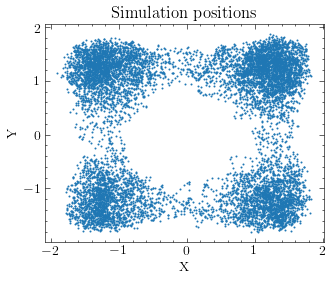

total number of hills: 1000
100 / 1000
200 / 1000
300 / 1000
400 / 1000
500 / 1000
600 / 1000
700 / 1000
800 / 1000
900 / 1000
1000 / 1000
The AAD of the FES is: 4.803515335940411


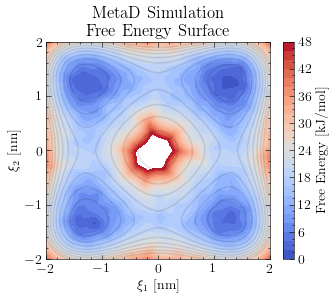

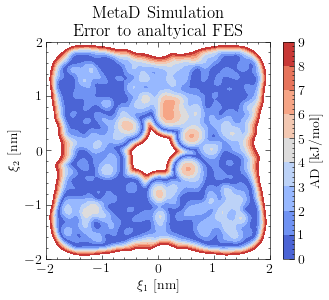

In [442]:
#Load HILLS and position file
HILLS = load_HILLS_2D()
[position_x, position_y] = laod_position_2D()

#Plot Trajectory
plt.scatter(position_x,position_y,s=1)
plt.title("Simulation positions")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()


#Define Constants
bw = 0.1  # bw: bandwidth for the KDE of the biased probability density
bw2 = bw**2        
kT = 1          # kT:       value of kT
stride = int(len(position_x) / len(HILLS[:,1]))     
const = (1 / (bw*np.sqrt(2*np.pi)*stride))
total_number_of_hills=len(HILLS[:,1])
print("total number of hills:", total_number_of_hills)

#Run MFI algorithm
[Ftot_den, Ftot_x, Ftot_y] = MFI_2D_simple(bw=0.075)

#integrate gradients
FES = FFT_intg_2D(Ftot_x, Ftot_y)

#Calculate error
(AD, AAD) = error_2D(FES)

#plot FES
plt.contourf(X, Y, FES, levels=range(0,50,2), cmap='coolwarm');
plt.colorbar(label="Free Energy [kJ/mol]")
plt.contour(X, Y, Z, levels=range(0,50,5), colors="black", alpha=0.1);
plt.xlabel(r"$\xi_1$ [nm]")
plt.ylabel(r"$\xi_2$ [nm]")
plt.title("MetaD Simulation \nFree Energy Surface")
plt.show()


#Plot Average deviation
plt.contourf(X, Y, AD, cmap='coolwarm', levels=range(0,10,1))#
plt.colorbar(label="AD [kJ/mol]")
plt.xlabel(r"$\xi_1$ [nm]")
plt.ylabel(r"$\xi_2$ [nm]")
plt.title("MetaD Simulation \nError to analtyical FES")
plt.show()


#Define new_name for later use    
Ftot_den0 = Ftot_den
Ftot_x0 = Ftot_x
Ftot_y0 = Ftot_y
    
#Save force terms in master list
master = []
master.append([Ftot_den, Ftot_x, Ftot_y])

### Additional Metadynamics and Umbrella sampling

In [443]:
os.chdir(path + "/HP_2D")

#Run Metadynamics with umbrella sampling in 2D    
def run_langevin2D_hp(length, kappa, ipos_x, ipos_y, sigma = 0.1, height = 1, biasfactor = 10):
    with open("plumed.dat","w") as f:
        print("""p: DISTANCE ATOMS=1,2 COMPONENTS
ff: MATHEVAL ARG=p.x,p.y PERIODIC=NO FUNC=(7*x^4-23*x^2+7*y^4-23*y^2)
bb: BIASVALUE ARG=ff
#Define Harmonic potential
RESTRAINT ARG=p.x,p.y AT={},{} KAPPA={},{} LABEL=restraint
METAD ARG=p.x,p.y PACE=100 SIGMA={},{} HEIGHT={} GRID_MIN=-3,-3 GRID_MAX=3,3 GRID_BIN=300,300 BIASFACTOR={} TEMP=120 CALC_RCT
PRINT FILE=position ARG=p.x,p.y STRIDE=10""".format(ipos_x,ipos_y,kappa,kappa, sigma, sigma, height, biasfactor),file=f)

    with open("input","w") as f:
        print("""temperature 1
tstep 0.005
friction 1
dimension 2
nstep {}
ipos 0.0,0.0
periodic false""".format(length),file=f)
        
    !plumed pesmd < input
    
    
def MFI_2D_hp(kappa, ipos_x, ipos_y, bw=0.1):

    # Initialize force terms
    Fbias_x = np.zeros((nbins, nbins))
    Fbias_y = np.zeros((nbins, nbins))
    Ftot_num_x = np.zeros((nbins, nbins))
    Ftot_num_y = np.zeros((nbins, nbins))
    Ftot_den = np.zeros((nbins, nbins))

    #Define Harmonic Force
    F_harmonic_x = float(kappa)*(X-float(ipos_x)) 
    F_harmonic_y = float(kappa)*(Y-float(ipos_y)) 


    for i in range(total_number_of_hills):
        # Build metadynamics potential
        s_x = HILLS[i, 1]  # center x-position of gausian
        s_y = HILLS[i, 2]  # center y-position of gausian
        sigma_meta2_x = HILLS[i, 3] ** 2  # width of gausian
        sigma_meta2_y = HILLS[i, 4] ** 2  # width of gausian
        gamma = HILLS[i, 6]
        height_meta = HILLS[i, 5] * ((gamma - 1) / (gamma))  # Height of Gausian

        kernelmeta = np.exp(-0.5 * (((X - s_x) ** 2) / sigma_meta2_x + ((Y - s_y) ** 2) / sigma_meta2_y))  # potential erorr in calc. of s-s_t
        Fbias_x = Fbias_x + height_meta * kernelmeta * ((X - s_x) / sigma_meta2_x);  ##potential erorr in calc. of s-s_t
        Fbias_y = Fbias_y + height_meta * kernelmeta * ((Y - s_y) / sigma_meta2_y);  ##potential erorr in calc. of s-s_t

        # Biased probability density component of the force
        # Etimate the biased proabability density p_t ^ b(s)
        pb_t = np.zeros((nbins, nbins))
        Fpbt_x = np.zeros((nbins, nbins))
        Fpbt_y = np.zeros((nbins, nbins))

        data_x = position_x[i * stride: (i + 1) * stride]
        data_y = position_y[i * stride: (i + 1) * stride]
        for j in range(stride):
            kernel = const * np.exp(- ((X - data_x[j]) ** 2 + (Y - data_y[j]) ** 2) / (2 * bw2) )
            pb_t = pb_t + kernel;
            Fpbt_x = Fpbt_x + kernel * (X - data_x[j]) / bw2
            Fpbt_y = Fpbt_y + kernel * (Y - data_y[j]) / bw2

        # Calculate Mean Force
        Ftot_den = Ftot_den + pb_t;
        # Calculate x-component of Force
        dfds_x = np.divide(Fpbt_x * kT, pb_t, out=np.zeros_like(Fpbt_x), where=pb_t != 0) + Fbias_x - F_harmonic_x
        Ftot_num_x = Ftot_num_x + pb_t * dfds_x
        Ftot_x = np.divide(Ftot_num_x, Ftot_den, out=np.zeros_like(Fpbt_x), where=Ftot_den != 0)
        # Calculate y-component of Force
        dfds_y = np.divide(Fpbt_y * kT, pb_t, out=np.zeros_like(Fpbt_y), where=pb_t != 0) + Fbias_y - F_harmonic_y
        Ftot_num_y = Ftot_num_y + pb_t * dfds_y
        Ftot_y = np.divide(Ftot_num_y, Ftot_den, out=np.zeros_like(Fpbt_y), where=Ftot_den != 0)

        if (i+1) % (total_number_of_hills/10) == 0: 
            print(str(i+1) + " / " + str(total_number_of_hills))
            
    return [Ftot_den, Ftot_x, Ftot_y]

In [444]:
os.chdir(path + "/HP_2D")

run_langevin2D_hp(length=50000, kappa=50, ipos_x=0, ipos_y=0, sigma = 0.1, height = 1, biasfactor = 10)

PLUMED: PLUMED is starting
PLUMED: Version: 2.7.0 (git: Unknown) compiled on Mar  8 2021 at 17:46:23
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /home/antoniu/.local/anaconda3/envs/plumed-masterclass/lib/plumed
PLUMED: For installed feature, see /home/antoniu/.local/anaconda3/envs/plumed-masterclass/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: pesmd
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 2
PLUMED: File suffix: 
PLUMED: FILE: plumed.dat
PLUMED: Action DISTANCE
PLUMED:   with label p
PLUMED:   between atoms 1 2
PLUMED:   using periodic boundary conditions
PLUMED:   added component to this action:  p.x 
PLUMED:   added component to this action:  p.y 
PLUMED:   added component to this action:  p.z 
PLUMED:   WARNING: components will not have the proper periodi

Doing step 6600
Doing step 6620
Doing step 6640
Doing step 6660
Doing step 6680
Doing step 6700
Doing step 6720
Doing step 6740
Doing step 6760
Doing step 6780
Doing step 6800
Doing step 6820
Doing step 6840
Doing step 6860
Doing step 6880
Doing step 6900
Doing step 6920
Doing step 6940
Doing step 6960
Doing step 6980
Doing step 7000
Doing step 7020
Doing step 7040
Doing step 7060
Doing step 7080
Doing step 7100
Doing step 7120
Doing step 7140
Doing step 7160
Doing step 7180
Doing step 7200
Doing step 7220
Doing step 7240
Doing step 7260
Doing step 7280
Doing step 7300
Doing step 7320
Doing step 7340
Doing step 7360
Doing step 7380
Doing step 7400
Doing step 7420
Doing step 7440
Doing step 7460
Doing step 7480
Doing step 7500
Doing step 7520
Doing step 7540
Doing step 7560
Doing step 7580
Doing step 7600
Doing step 7620
Doing step 7640
Doing step 7660
Doing step 7680
Doing step 7700
Doing step 7720
Doing step 7740
Doing step 7760
Doing step 7780
Doing step 7800
Doing step 7820
Doing st

Doing step 17400
Doing step 17420
Doing step 17440
Doing step 17460
Doing step 17480
Doing step 17500
Doing step 17520
Doing step 17540
Doing step 17560
Doing step 17580
Doing step 17600
Doing step 17620
Doing step 17640
Doing step 17660
Doing step 17680
Doing step 17700
Doing step 17720
Doing step 17740
Doing step 17760
Doing step 17780
Doing step 17800
Doing step 17820
Doing step 17840
Doing step 17860
Doing step 17880
Doing step 17900
Doing step 17920
Doing step 17940
Doing step 17960
Doing step 17980
Doing step 18000
Doing step 18020
Doing step 18040
Doing step 18060
Doing step 18080
Doing step 18100
Doing step 18120
Doing step 18140
Doing step 18160
Doing step 18180
Doing step 18200
Doing step 18220
Doing step 18240
Doing step 18260
Doing step 18280
Doing step 18300
Doing step 18320
Doing step 18340
Doing step 18360
Doing step 18380
Doing step 18400
Doing step 18420
Doing step 18440
Doing step 18460
Doing step 18480
Doing step 18500
Doing step 18520
Doing step 18540
Doing step 185

Doing step 27520
Doing step 27540
Doing step 27560
Doing step 27580
Doing step 27600
Doing step 27620
Doing step 27640
Doing step 27660
Doing step 27680
Doing step 27700
Doing step 27720
Doing step 27740
Doing step 27760
Doing step 27780
Doing step 27800
Doing step 27820
Doing step 27840
Doing step 27860
Doing step 27880
Doing step 27900
Doing step 27920
Doing step 27940
Doing step 27960
Doing step 27980
Doing step 28000
Doing step 28020
Doing step 28040
Doing step 28060
Doing step 28080
Doing step 28100
Doing step 28120
Doing step 28140
Doing step 28160
Doing step 28180
Doing step 28200
Doing step 28220
Doing step 28240
Doing step 28260
Doing step 28280
Doing step 28300
Doing step 28320
Doing step 28340
Doing step 28360
Doing step 28380
Doing step 28400
Doing step 28420
Doing step 28440
Doing step 28460
Doing step 28480
Doing step 28500
Doing step 28520
Doing step 28540
Doing step 28560
Doing step 28580
Doing step 28600
Doing step 28620
Doing step 28640
Doing step 28660
Doing step 286

Doing step 38200
Doing step 38220
Doing step 38240
Doing step 38260
Doing step 38280
Doing step 38300
Doing step 38320
Doing step 38340
Doing step 38360
Doing step 38380
Doing step 38400
Doing step 38420
Doing step 38440
Doing step 38460
Doing step 38480
Doing step 38500
Doing step 38520
Doing step 38540
Doing step 38560
Doing step 38580
Doing step 38600
Doing step 38620
Doing step 38640
Doing step 38660
Doing step 38680
Doing step 38700
Doing step 38720
Doing step 38740
Doing step 38760
Doing step 38780
Doing step 38800
Doing step 38820
Doing step 38840
Doing step 38860
Doing step 38880
Doing step 38900
Doing step 38920
Doing step 38940
Doing step 38960
Doing step 38980
Doing step 39000
Doing step 39020
Doing step 39040
Doing step 39060
Doing step 39080
Doing step 39100
Doing step 39120
Doing step 39140
Doing step 39160
Doing step 39180
Doing step 39200
Doing step 39220
Doing step 39240
Doing step 39260
Doing step 39280
Doing step 39300
Doing step 39320
Doing step 39340
Doing step 393

Doing step 48180
Doing step 48200
Doing step 48220
Doing step 48240
Doing step 48260
Doing step 48280
Doing step 48300
Doing step 48320
Doing step 48340
Doing step 48360
Doing step 48380
Doing step 48400
Doing step 48420
Doing step 48440
Doing step 48460
Doing step 48480
Doing step 48500
Doing step 48520
Doing step 48540
Doing step 48560
Doing step 48580
Doing step 48600
Doing step 48620
Doing step 48640
Doing step 48660
Doing step 48680
Doing step 48700
Doing step 48720
Doing step 48740
Doing step 48760
Doing step 48780
Doing step 48800
Doing step 48820
Doing step 48840
Doing step 48860
Doing step 48880
Doing step 48900
Doing step 48920
Doing step 48940
Doing step 48960
Doing step 48980
Doing step 49000
Doing step 49020
Doing step 49040
Doing step 49060
Doing step 49080
Doing step 49100
Doing step 49120
Doing step 49140
Doing step 49160
Doing step 49180
Doing step 49200
Doing step 49220
Doing step 49240
Doing step 49260
Doing step 49280
Doing step 49300
Doing step 49320
Doing step 493

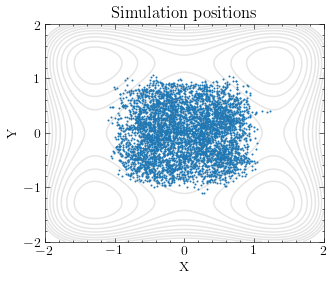

total number of hills: 500
50 / 500
100 / 500
150 / 500
200 / 500
250 / 500
300 / 500
350 / 500
400 / 500
450 / 500
500 / 500
The AAD of the FES is: 23.27638676903054


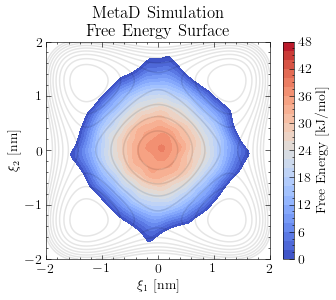

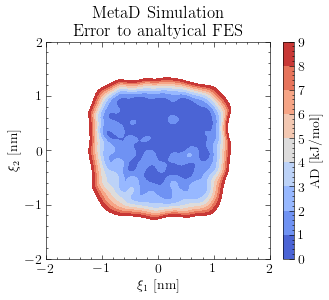

In [445]:
#Load HILLS and position file
HILLS = load_HILLS_2D()
[position_x, position_y] = laod_position_2D()

#Plot Trajectory
plt.scatter(position_x,position_y,s=1)
plt.contour(X, Y, Z, levels=np.linspace(0,50,11), alpha=0.2, colors="grey")
plt.title("Simulation positions")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()


#Define Constants
bw = 0.1  # bw: bandwidth for the KDE of the biased probability density
bw2 = bw**2        
kT = 1          # kT:       value of kT
stride = int(len(position_x) / len(HILLS[:,1]))     
const = (1 / (bw*np.sqrt(2*np.pi)*stride))
total_number_of_hills=len(HILLS[:,1])
print("total number of hills:", total_number_of_hills)

#Run MFI algorithm
[Ftot_den, Ftot_x, Ftot_y] = MFI_2D_hp(kappa=50, ipos_x=0, ipos_y=0, bw = 0.075)

#integrate gradients
FES = FFT_intg_2D(Ftot_x, Ftot_y)

FES = FES + (Z[100,100] - FES[100,100])


#Calculate error
(AD, AAD) = error_2D(FES)

#plot FES
plt.contourf(X, Y, FES, levels=range(0,50,2), cmap='coolwarm');
plt.colorbar(label="Free Energy [kJ/mol]")
plt.contour(X, Y, Z, levels=range(0,50,5), colors="black", alpha=0.1);
plt.xlabel(r"$\xi_1$ [nm]")
plt.ylabel(r"$\xi_2$ [nm]")
plt.title("MetaD Simulation \nFree Energy Surface")
plt.show()


#Plot Average deviation
plt.contourf(X, Y, AD, cmap='coolwarm', levels=range(0,10,1))#
plt.colorbar(label="AD [kJ/mol]")
plt.xlabel(r"$\xi_1$ [nm]")
plt.ylabel(r"$\xi_2$ [nm]")
plt.title("MetaD Simulation \nError to analtyical FES")
plt.show()


#Save force terms in master list
master.append([Ftot_den, Ftot_x, Ftot_y])

### Patch the simulations

In [447]:
os.chdir(path)

In [448]:
%run Functions.ipynb

The AAD of the FES is: 3.932961504047815


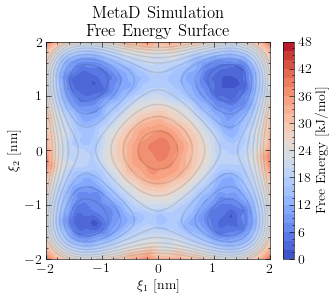

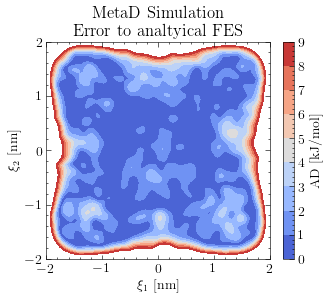

In [451]:
[Ftot_den_patch, Ftot_x_patch, Ftot_y_patch] = patch_2D(master)

#integrate gradients
FES_patch = FFT_intg_2D(Ftot_x_patch, Ftot_y_patch)



#Calculate error
(AD_patch, AAD_patch) = error_2D(FES_patch)


#plot FES
plt.contourf(X, Y, FES_patch, levels=range(0,50,2), cmap='coolwarm');
plt.colorbar(label="Free Energy [kJ/mol]")
plt.contour(X, Y, Z, levels=range(0,50,5), colors="black", alpha=0.1);
plt.xlabel(r"$\xi_1$ [nm]")
plt.ylabel(r"$\xi_2$ [nm]")
plt.title("MetaD Simulation \nFree Energy Surface")
plt.show()


#Plot Average deviation
plt.contourf(X, Y, AD_patch, cmap='coolwarm', levels=range(0,10,1))#
plt.colorbar(label="AD [kJ/mol]")
plt.xlabel(r"$\xi_1$ [nm]")
plt.ylabel(r"$\xi_2$ [nm]")
plt.title("MetaD Simulation \nError to analtyical FES")
plt.show()

In [27]:
# low_x = -0.1
# low_y = -0.1
# up_x = 0.1
# up_y = 0.1
# kappa = 25.0
# length_2D = 200000

In [422]:
# x = np.linspace(-2,2,200)
# y = 7*x**4-23*x**2
# y = y - min(y)
# print(x[100])

# low_wp = np.zeros_like(y)
# up_wp = np.zeros_like(y)

# low_wp = np.where(x<=low_x, kappa * (x-low_x)**2 , 0)
# up_wp = np.where(x>=up_x, kappa * (x-up_x)**2, 0)

# plt.plot(x, y, label="original f")
# plt.plot(x, low_wp - min(low_wp),label="lower wall potential")
# plt.plot(x, up_wp - min(up_wp),label="upper wall potential")
# plt.plot(x, y + low_wp + up_wp - min(y + low_wp + up_wp), label="f + WP" )
# plt.ylim(-2,20)
# plt.legend()

In [36]:
# os.chdir("/home/antoniu/Desktop/plots/Jupyter_Notebook/MFI_2D_WP")

# with open("plumed.dat","w") as f:
#     print("""#Define system as distance between two atoms
# p: DISTANCE ATOMS=1,2 COMPONENTS
# #Define Force field
# ff: MATHEVAL ARG=p.x,p.y PERIODIC=NO FUNC=(7*x^4-23*x^2+7*y^4-23*y^2)
# bb: BIASVALUE ARG=ff
# #Define Wall potential
# uwall: UPPER_WALLS ARG=p.x,p.y AT={},{} KAPPA={},{}
# lwall: LOWER_WALLS ARG=p.x,p.y AT={},{} KAPPA={},{}
# #Define Histroy dependet bias potentail
# METAD ARG=p.x,p.y PACE=100 SIGMA=0.1,0.1 HEIGHT=1 GRID_MIN=-3,-3 GRID_MAX=3,3 GRID_BIN=300,300 BIASFACTOR=10 TEMP=120 CALC_RCT
# PRINT FILE=position ARG=p.x,p.y STRIDE=10
# """.format(low_x,low_y,kappa,kappa,up_x,up_y,kappa,kappa),file=f)
        
# with open("input","w") as f:
#     print("""temperature 1
# tstep 0.005
# friction 1
# dimension 2
# nstep {}
# ipos 0.0,0.0
# periodic false""".format(length_2D),file=f)

In [423]:
# %%bash
# #Make sure execution is in right folder
# cd /home/antoniu/Desktop/plots/Jupyter_Notebook/MFI_2D_WP

# #Start Meta Dynamic simulation
# plumed pesmd < input

In [424]:
# #Read data
# for file in glob.glob("HILLS"):
#     hills = np.loadtxt(file)
#     hills = np.concatenate(([hills[0]], hills[:-1]))
#     hills[0][5] = 0
#     HILLS = hills

# for file1 in glob.glob("position"):
#     colvar = np.loadtxt(file1)
#     position_x = colvar[:-1, 1]
#     position_y = colvar[:-1, 2]

# #Define Constants
# stride = int(len(position_x)/len(HILLS))     # stride:   number of points in the COLVAR file per point in the HILLS file
# bw = 0.1  # bw: bandwidth for the KDE of the biased probability density
# bw2 = bw**2        
# kT = 1          # kT:       value of kT
# const = (1 / (bw*np.sqrt(2*np.pi)*stride));


# total_number_of_hills=len(HILLS[:,1])
# count = 0
# print("Total no. of HILLS for following simulation: " + str(total_number_of_hills))

In [425]:
# count = 0
# # Initialize force terms
# Fbias_x = np.zeros((nbins, nbins))
# Fbias_y = np.zeros((nbins, nbins))
# Ftot_num_x = np.zeros((nbins, nbins))
# Ftot_num_y = np.zeros((nbins, nbins))
# Ftot_den = np.zeros((nbins, nbins))

# #Define Harmonic Force
# F_harmonic = np.zeros((nbins, nbins))
# F_harmonic += np.where( X <= low_x, kappa/2 * (X-low_x), 0 )
# F_harmonic += np.where( Y <= low_y, kappa/2 * (Y-low_y), 0 )
# F_harmonic += np.where( X >= up_x , kappa/2 * (X-up_x), 0 )
# F_harmonic += np.where( X >= up_y , kappa/2 * (Y-up_y), 0 )


# for i in range(total_number_of_hills):
#     count += 1
#     # Build metadynamics potential
#     s_x = HILLS[i, 1]  # center x-position of gausian
#     s_y = HILLS[i, 2]  # center y-position of gausian
#     sigma_meta2_x = HILLS[i, 3] ** 2  # width of gausian
#     sigma_meta2_y = HILLS[i, 4] ** 2  # width of gausian
#     gamma = HILLS[i, 6]
#     height_meta = HILLS[i, 5] * ((gamma - 1) / (gamma))  # Height of Gausian
    
#     kernelmeta = np.exp(-0.5 * (((X - s_x) ** 2) / sigma_meta2_x + ((Y - s_y) ** 2) / sigma_meta2_y))  # potential erorr in calc. of s-s_t
#     Fbias_x = Fbias_x + height_meta * kernelmeta * ((X - s_x) / sigma_meta2_x);  ##potential erorr in calc. of s-s_t
#     Fbias_y = Fbias_y + height_meta * kernelmeta * ((Y - s_y) / sigma_meta2_y);  ##potential erorr in calc. of s-s_t

#     # Biased probability density component of the force
#     # Etimate the biased proabability density p_t ^ b(s)
#     pb_t = np.zeros((nbins, nbins))
#     Fpbt_x = np.zeros((nbins, nbins))
#     Fpbt_y = np.zeros((nbins, nbins))
    
#     data_x = position_x[i * stride: (i + 1) * stride]
#     data_y = position_y[i * stride: (i + 1) * stride]
#     for j in range(stride):
#         kernel = const * np.exp(- ((X - data_x[j]) ** 2 + (Y - data_y[j]) ** 2) / (2 * bw2) )
#         pb_t = pb_t + kernel;
#         Fpbt_x = Fpbt_x + kernel * (X - data_x[j]) / bw2
#         Fpbt_y = Fpbt_y + kernel * (Y - data_y[j]) / bw2

#     # Calculate Mean Force
#     Ftot_den = Ftot_den + pb_t;
#     # Calculate x-component of Force
#     dfds_x = np.divide(Fpbt_x * kT, pb_t, out=np.zeros_like(Fpbt_x), where=pb_t != 0) + Fbias_x - F_harmonic_x
#     Ftot_num_x = Ftot_num_x + pb_t * dfds_x
#     Ftot_x = np.divide(Ftot_num_x, Ftot_den, out=np.zeros_like(Fpbt_x), where=Ftot_den != 0)
#     # Calculate y-component of Force
#     dfds_y = np.divide(Fpbt_y * kT, pb_t, out=np.zeros_like(Fpbt_y), where=pb_t != 0) + Fbias_y - F_harmonic_y
#     Ftot_num_y = Ftot_num_y + pb_t * dfds_y
#     Ftot_y = np.divide(Ftot_num_y, Ftot_den, out=np.zeros_like(Fpbt_y), where=Ftot_den != 0)

#     if count % (total_number_of_hills/20) == 0: 
#         print(str(count) + " / " + str(total_number_of_hills))


In [426]:
# #plot recorded trajectory
# plt.scatter(position_x,position_y,s=1)
# plt.title("Simulation positions")
# plt.xlabel("X")
# plt.ylabel("Y")
# plt.xlim(-2,2)
# plt.ylim(-2,2)

In [41]:
# #Patch terms together
# master = []
# master.append([Ftot_den0, Ftot_x0, Ftot_y0])
# master.append([Ftot_den, Ftot_x, Ftot_y])

# Ftot_x = np.zeros((nbins, nbins))
# Ftot_y = np.zeros((nbins, nbins))
# Ftot_den = np.zeros((nbins, nbins))

# for i in range(len(master)):
#     Ftot_x += master[i][0] * master[i][1]
#     Ftot_y += master[i][0] * master[i][2]
#     Ftot_den += master[i][0]

# Ftot_x = np.divide(Ftot_x, Ftot_den, out=np.zeros_like(Ftot_x), where=Ftot_den != 0)
# Ftot_y = np.divide(Ftot_y, Ftot_den, out=np.zeros_like(Ftot_y), where=Ftot_den != 0)

In [427]:
# FES = FFTIntegration(Ftot_x, Ftot_y)

# AD = abs(FES - Z)
# AAD = sum(sum(AD))/(nbins**2)
# print("The AAD of the FES is: " + str(AAD))

In [428]:
# plt.figure(1)
# plt.contourf(X, Y, FES, levels=range(0,50,2), cmap='coolwarm');
# plt.colorbar();
# plt.contour(X, Y, Z, levels=range(0,50,5), colors="black", alpha=0.1);
# plt.title("MFI_2D simulation ")
# plt.xlabel("X")
# plt.ylabel("Y")

# plt.figure(2)
# plt.contourf(X, Y, AD, levels=range(0,10,1), cmap='coolwarm')#
# plt.title("AD")
# plt.xlabel("X")
# plt.ylabel("Y")
# plt.colorbar()